# Bradley-Terry-Luce Model 

## Dummy data

In [1]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    'A': [np.nan, 3, 0, 4],
    'B': [2, np.nan, 3, 0],
    'C': [0, 5, np.nan, 3],
    'D': [1, 0, 1, np.nan]
}, index=['A', 'B', 'C', 'D'])

df

,A,B,C,D
A,NaN,2.0,0.0,1.0
B,3.0,NaN,5.0,0.0
C,0.0,3.0,NaN,1.0
D,4.0,0.0,3.0,NaN


In [2]:
def get_estimate(i, p, df):
    get_prob = lambda i, j: np.nan if i == j else p.iloc[i] + p.iloc[j]
    n = df.iloc[i].sum()
    
    d_n = df.iloc[i] + df.iloc[:, i]
    d_d = pd.Series([get_prob(i, j) for j in range(len(p))], index=p.index)
    d = (d_n / d_d).sum()
    
    return n / d

def estimate_p(p, df):
    return pd.Series([get_estimate(i, p, df) for i in range(df.shape[0])], index=p.index)


def iterate(df, p=None, n=20, sorted=True):
    if p is None:
        p = pd.Series([1 for _ in range(df.shape[0])], index=list(df.columns))
        
    estimates = [p]
    
    for _ in range(n):
        p = estimate_p(p, df)
        p = p / p.sum()
        estimates.append(p)
    
    p = p.sort_values(ascending=False) if sorted else p
    return p, pd.DataFrame(estimates)

p, estimates = iterate(df, n=100)

In [3]:
p

D    0.492133
B    0.226152
C    0.143022
A    0.138692
dtype: float64

In [4]:
estimates.tail()

,A,B,C,D
96,0.138692,0.226152,0.143022,0.492133
97,0.138692,0.226152,0.143022,0.492133
98,0.138692,0.226152,0.143022,0.492133
99,0.138692,0.226152,0.143022,0.492133
100,0.138692,0.226152,0.143022,0.492133


## 2021 NFL data

In [5]:
def get_winner(r):
    if r.score1 > r.score2:
        return r.team1
    elif r.score1 < r.score2:
        return r.team2
    else:
        return np.nan
    
def get_loser(r):
    if r.score1 > r.score2:
        return r.team2
    elif r.score1 < r.score2:
        return r.team1
    else:
        return np.nan
    
nfl = pd.read_csv('./nfl/2021.csv')
nfl['team1'] = nfl['team1'].apply(lambda s: s.strip())
nfl['team2'] = nfl['team2'].apply(lambda s: s.strip())
nfl = nfl.drop_duplicates()
nfl['winner'] = nfl.apply(get_winner, axis=1)
nfl['loser'] = nfl.apply(get_loser, axis=1)

nfl.head()

,team1,team2,score1,score2,week,winner,loser
0,Cowboys,Buccaneers,29,31,1,Buccaneers,Cowboys
1,Eagles,Falcons,32,6,1,Eagles,Falcons
2,Chargers,Washington,20,16,1,Chargers,Washington
3,Steelers,Bills,23,16,1,Steelers,Bills
4,49ers,Lions,41,33,1,49ers,Lions


In [6]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

w = nfl.winner.value_counts().sort_index()
l = nfl.loser.value_counts().sort_index()

wl_df = pd.DataFrame([w, l]).T.rename(columns={'winner': 'wins', 'loser': 'losses'})
wl_df = wl_df.fillna(0)
wl_df['n'] = wl_df.wins + wl_df.losses
wl_df

,wins,losses,n
49ers,5.0,5.0,10.0
Bears,4.0,7.0,11.0
Bengals,6.0,4.0,10.0
Bills,7.0,4.0,11.0
Broncos,5.0,5.0,10.0
Browns,6.0,5.0,11.0
Buccaneers,7.0,3.0,10.0
Cardinals,9.0,2.0,11.0
Chargers,6.0,4.0,10.0
Chiefs,7.0,4.0,11.0


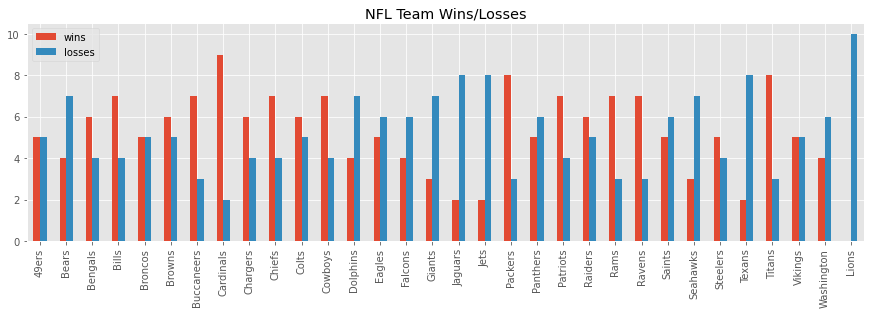

In [7]:
_ = wl_df[['wins', 'losses']].plot(kind='bar', figsize=(15, 4), title='NFL Team Wins/Losses')

In [8]:
teams = sorted(list(set(nfl.team1) | set(nfl.team2)))
t2i = {t: i for i, t in enumerate(teams)}

df = nfl\
    .groupby(['winner', 'loser'])\
    .agg('count')\
    .drop(columns=['team2', 'score1', 'score2'])\
    .rename(columns={'team1': 'n'})\
    .reset_index()
df['r'] = df['winner'].apply(lambda t: t2i[t])
df['c'] = df['loser'].apply(lambda t: t2i[t])

n_teams = len(teams)
mat = np.zeros([n_teams, n_teams])

for _, r in df.iterrows():
    mat[r.r, r.c] = r.n
    
df = pd.DataFrame(mat, columns=teams, index=teams)

In [9]:
p, estimates = iterate(df, n=100)

In [10]:
p

Cardinals     0.122781
Packers       0.069247
Titans        0.068104
Chiefs        0.061767
Ravens        0.053967
Rams          0.052400
Chargers      0.050219
Buccaneers    0.047603
Cowboys       0.046897
Steelers      0.034552
Raiders       0.031772
Bills         0.030949
Patriots      0.030948
Vikings       0.030064
Browns        0.029378
Bengals       0.029071
Colts         0.024912
49ers         0.022290
Broncos       0.019892
Saints        0.019743
Eagles        0.018422
Washington    0.017573
Panthers      0.015306
Seahawks      0.012831
Falcons       0.011700
Giants        0.011220
Bears         0.010692
Dolphins      0.009925
Texans        0.005485
Jets          0.005413
Jaguars       0.004875
Lions         0.000000
dtype: float64

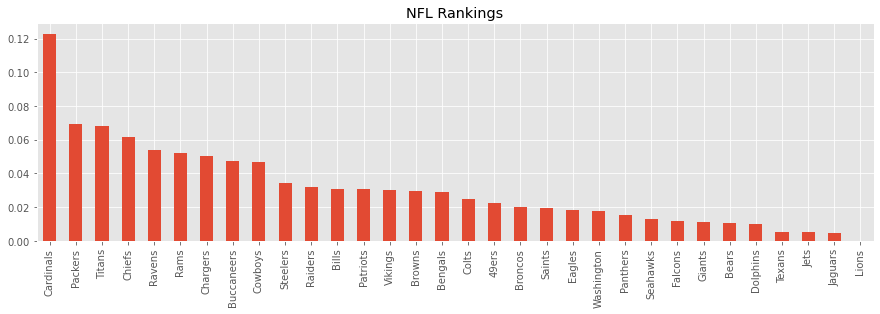

In [11]:
_ = p.plot(kind='bar', figsize=(15, 4), title='NFL Rankings')

## 2021 NBA data

In [12]:
def get_winner(r):
    if r.a_score > r.h_score:
        return r.a_team
    elif r.a_score < r.h_score:
        return r.h_team
    else:
        return np.nan
    
def get_loser(r):
    if r.a_score > r.h_score:
        return r.h_team
    elif r.a_score < r.h_score:
        return r.a_team
    else:
        return np.nan
    
nba = pd.read_csv('./nba/2021.csv')
nba['a_team'] = nba['a_team'].apply(lambda s: s.strip())
nba['h_team'] = nba['h_team'].apply(lambda s: s.strip())
nba['winner'] = nba.apply(get_winner, axis=1)
nba['loser'] = nba.apply(get_loser, axis=1)

nba.head()

,a_team,h_team,a_score,h_score,preseason,winner,loser
0,Nets,Lakers,123,97,True,Nets,Lakers
1,76ers,Raptors,107,123,True,Raptors,76ers
2,Hawks,Heat,99,125,True,Heat,Hawks
3,Magic,Celtics,97,98,True,Celtics,Magic
4,Pelicans,Timberwolves,114,117,True,Timberwolves,Pelicans


In [13]:
w = nba.winner.value_counts().sort_index()
l = nba.loser.value_counts().sort_index()

wl_df = pd.DataFrame([w, l]).T.rename(columns={'winner': 'wins', 'loser': 'losses'})
wl_df = wl_df.fillna(0)
wl_df['n'] = wl_df.wins + wl_df.losses
wl_df

,wins,losses,n
76ers,12,12,24
Bucks,13,12,25
Bulls,17,8,25
Cavaliers,12,13,25
Celtics,12,12,24
Clippers,12,11,23
Grizzlies,12,13,25
Hawks,13,12,25
Heat,18,8,26
Hornets,14,12,26


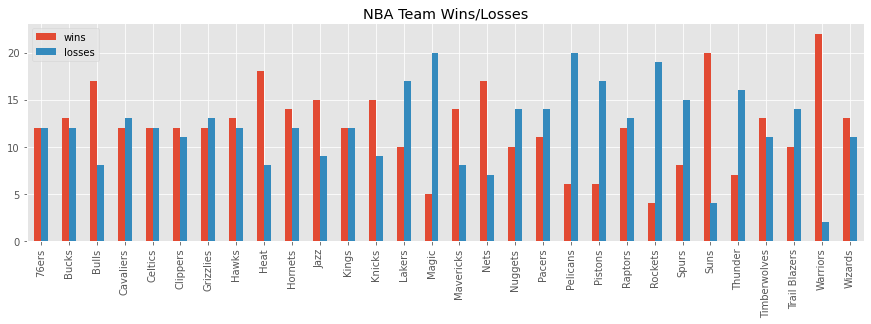

In [14]:
_ = wl_df[['wins', 'losses']].plot(kind='bar', figsize=(15, 4), title='NBA Team Wins/Losses')

In [15]:
teams = sorted(list(set(nba.a_team) | set(nba.h_team)))
t2i = {t: i for i, t in enumerate(teams)}

df = nba\
    .groupby(['winner', 'loser'])\
    .agg('count')\
    .drop(columns=['h_team', 'a_score', 'h_score'])\
    .rename(columns={'a_team': 'n'})\
    .reset_index()
df['r'] = df['winner'].apply(lambda t: t2i[t])
df['c'] = df['loser'].apply(lambda t: t2i[t])

n_teams = len(teams)
mat = np.zeros([n_teams, n_teams])

for _, r in df.iterrows():
    mat[r.r, r.c] = r.n
    
df = pd.DataFrame(mat, columns=teams, index=teams)

df.shape

(30, 30)

In [16]:
p, estimates = iterate(df, n=100)
p

Warriors         0.234286
Suns             0.108259
Nets             0.056412
Bulls            0.047578
Heat             0.046572
Mavericks        0.041772
Knicks           0.031417
Jazz             0.030731
Hornets          0.028883
Hawks            0.027017
Clippers         0.026891
Cavaliers        0.025853
Wizards          0.024828
Kings            0.024613
Timberwolves     0.023990
76ers            0.023138
Trail Blazers    0.022861
Grizzlies        0.022233
Raptors          0.020807
Bucks            0.020189
Celtics          0.018374
Nuggets          0.018167
Pacers           0.018018
Lakers           0.014244
Spurs            0.008889
Thunder          0.008728
Pelicans         0.008001
Pistons          0.007736
Magic            0.005067
Rockets          0.004447
dtype: float64

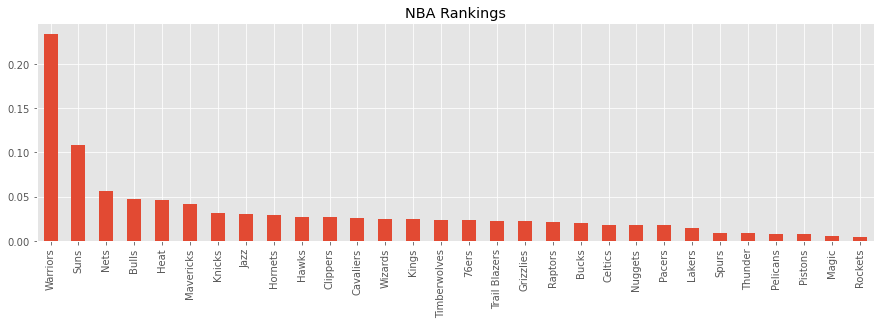

In [17]:
_ = p.plot(kind='bar', figsize=(15, 4), title='NBA Rankings')

## References

- [Pairwise comparison](https://en.wikipedia.org/wiki/Pairwise_comparison)
- [Bradley-Terry model](https://en.wikipedia.org/wiki/Bradley%E2%80%93Terry_model)
- [choix Code](https://github.com/lucasmaystre/choix)
- [choix Documentation](https://choix.lum.li/en/latest/index.html)
- [From pairwise comparisons to ranking - python](https://datascience.stackexchange.com/questions/18828/from-pairwise-comparisons-to-ranking-python)
- [prefmod](https://cran.r-project.org/web/packages/prefmod/index.html)
- [Paired Comparison Preference Models](https://statmath.wu.ac.at/people/hatz/preference/tag4/tag4_handouts.pdf)
- [prefmod: An R Package for Modeling Preferences Based on Paired Comparisons, Rankings, or Ratings](https://www.jstatsoft.org/article/view/v048i10)
- [Method of Paired Comparisons](https://www.amazon.com/dp/0852640137)
- [Who's #1?: The Science of Rating and Ranking](https://www.amazon.com/dp/0691154228)
- [How to get started with rating and ranking based on pairwise competition data?](https://stats.stackexchange.com/questions/30976/how-to-get-started-with-rating-and-ranking-based-on-pairwise-competition-data/30996)
- [How to fit Bradley–Terry–Luce model in R, without complicated formula?](https://stats.stackexchange.com/questions/26994/how-to-fit-bradley-terry-luce-model-in-r-without-complicated-formula)
- [BradleyTerry2](https://github.com/hturner/BradleyTerry2)